##### Copyright 2025 Google LLC.

In [ ]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Gemini API: Automated Invoice and Form Data Extraction with Gemini API & Pydantic

This notebook demonstrates how you can convert a PDF file so that it can be read by the Gemini API.

<a target="_blank" href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/examples/Pdf_structured_outputs_on_invoices_and_forms.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" height=30/></a>

## 1. Set up Environment and create inference Client

The first task is to install the `google-genai` [Python SDK](https://googleapis.github.io/python-genai/) and obtain an API key. If you don”t have a can get one from Google AI Studio: [Get a Gemini API key](https://aistudio.google.com/app/apikey). If you are new to Google Colab checkout the [quickstart](../quickstarts/Authentication.ipynb)).


In [ ]:
%pip install "google-genai>=1"

Once you have the SDK and API key, you can create a client and define the model you are going to use the new Gemini 2.0 Flash model, which is available via [free tier](https://ai.google.dev/pricing#2_0flash) with 1,500 request per day (at 2025-02-06).

In [6]:
from google import genai
from google.colab import userdata
api_key = userdata.get("gemini_wataru") # If you are not using Colab you can set the API key directly

# Create a client
client = genai.Client(api_key=api_key)

# Define the model you are going to use
model_id =  "gemini-2.0-flash" # or "gemini-2.0-flash-lite"  , "gemini-2.5-flash-preview-04-17","gemini-2.5-pro-exp-05-06"

*Note: If you want to use Vertex AI see [here](https://googleapis.github.io/python-genai/#create-a-client) how to create your client*

## 2. Work with PDFs and other files

Gemini models are able to process [images and videos](https://ai.google.dev/gemini-api/docs/vision?lang=python#image-input), which can used with base64 strings or using the `files`api. After uploading the file you can include the file uri in the call directly. The Python API includes a [upload](https://googleapis.github.io/python-genai/#upload) and [delete](https://googleapis.github.io/python-genai/#delete) method.

For this example you have 2 PDFs samples, one basic invoice and on form with and written values.


In [7]:
!wget -q -O handwriting_form.pdf https://storage.googleapis.com/generativeai-downloads/data/pdf_structured_outputs/handwriting_form.pdf
!wget -q -O invoice.pdf https://storage.googleapis.com/generativeai-downloads/data/pdf_structured_outputs/invoice.pdf

In [4]:
!pwd

/content


You can now upload the files using our client with the `upload` method. Let's try this for one of the files.


In [8]:
invoice_pdf = client.files.upload(file="invoice.pdf", config={'display_name': 'invoice'})

_Note: The File API lets you store up to 20 GB of files per project, with a per-file maximum size of 2 GB. Files are stored for 48 hours. They can be accessed in that period with your API key, but they cannot be downloaded. File uploads are available at no cost._

After a file is uploaded you can check to how many tokens it got converted. This not only help us understand the context you are working with it also helps to keep track of the cost.

In [9]:
file_size = client.models.count_tokens(model=model_id,contents=invoice_pdf)
print(f'File: {invoice_pdf.display_name} equals to {file_size.total_tokens} tokens')
# File: invoice equals to 821 tokens

File: invoice equals to 259 tokens


## 3. Structured outputs with Gemini 2.0 and Pydantic

Structured Outputs is a feature that ensures Gemini always generate responses that adhere to a predefined format, such as JSON Schema. This means you have more control over the output and how to integrate it into our application as it is guaranteed to return a valid JSON object with the schema you define.

Gemini 2.0 currenlty supports 3 dfferent types of how to define a JSON schemas:
- A single python type, as you would use in a [typing annotation](https://docs.python.org/3/library/typing.html).
- A Pydantic [BaseModel](https://docs.pydantic.dev/latest/concepts/models/)
- A dict equivalent of [genai.types.Schema](https://googleapis.github.io/python-genai/genai.html#genai.types.Schema) / [Pydantic BaseModel](https://docs.pydantic.dev/latest/concepts/models/)

Lets look at quick text-based example.

In [10]:
from pydantic import BaseModel, Field

# Define a Pydantic model
# Use the Field class to add a description and default value to provide more context to the model
class Topic(BaseModel):
    name: str = Field(description="The name of the topic")

class Person(BaseModel):
    first_name: str = Field(description="The first name of the person")
    last_name: str = Field(description="The last name of the person")
    age: int = Field(description="The age of the person, if not provided please return 0")
    work_topics: list[Topic] = Field(description="The fields of interest of the person, if not provided please return an empty list")


# Define the prompt
prompt = "Philipp Schmid is a Senior AI Developer Relations Engineer at Google DeepMind working on Gemini, Gemma with the mission to help every developer to build and benefit from AI in a responsible way.  "

# Generate a response using the Person model
response = client.models.generate_content(model=model_id, contents=prompt, config={'response_mime_type': 'application/json', 'response_schema': Person})

# print the response as a json string
print(response.text)

# sdk automatically converts the response to the pydantic model
philipp: Person = response.parsed

# access an attribute of the json response
print(f"First name is {philipp.first_name}")

{
  "first_name": "Philipp",
  "last_name": "Schmid",
  "age": 0,
  "work_topics": [
    {
      "name": "AI"
    },
    {
      "name": "Gemini"
    },
    {
      "name": "Gemma"
    }
  ]
}
First name is Philipp


## 4. Extract Structured data from PDFs using Gemini 2.0

Now, let's combine the File API and structured output to extract information from our PDFs. You can create a simple method that accepts a local file path and a pydantic model and return the structured data for us. The method will:

1. Upload the file to the File API
2. Generate a structured response using the Gemini API
3. Convert the response to the pydantic model and return it


In [11]:
def extract_structured_data(file_path: str, model: BaseModel):
    # Upload the file to the File API
    file = client.files.upload(file=file_path, config={'display_name': file_path.split('/')[-1].split('.')[0]})
    # Generate a structured response using the Gemini API
    prompt = f"Extract the structured data from the following PDF file"
    response = client.models.generate_content(model=model_id, contents=[prompt, file], config={'response_mime_type': 'application/json', 'response_schema': model})
    # Convert the response to the pydantic model and return it
    return response.parsed

In our Example every PDF is a different to each other. So you want to define unique Pydantic models for each PDF to show the performance of the Gemini 2.0. If you have very similar PDFs and want to extract the same information you can use the same model for all of them.

- `Invoice.pdf` : Extract the invoice number, date and all list items with description, quantity and gross worth and the total gross worth
- `handwriting_form.pdf` : Extract the form number, plan start date and the plan liabilities beginning of the year and end of the year

_Note: Using Pydantic features you can add more context to the model to make it more accurate as well as some validation to the data. Adding a comprehensive description can significantly improve the performance of the model. Libraries like [instructor](https://python.useinstructor.com/) added automatic retries based on validation errors, which can be a great help, but come at the cost of additional requests._


### Invoice.pdf

![Invoice.pdf](https://storage.googleapis.com/generativeai-downloads/data/pdf_structured_outputs/invoice.png)

In [22]:
from pydantic import BaseModel, Field

class Seller(BaseModel):
    name: str = Field(description="The name of the seller")
    address: str = Field(description="The address of the seller")
    Tax_ID: str = Field(description="The Tax ID of the seller")
    IBAN: str = Field(description="The IBAN of the seller")

class Buyer(BaseModel):
    name: str = Field(description="The name of the buyer")
    address: str = Field(description="The address of the buyer")
    Tax_ID: str = Field(description="The Tax ID of the buyer")
    IBAN: str = Field(description="The IBAN of the buyer")

class Item(BaseModel):
    description: str = Field(description="The description of the item")
    quantity: float = Field(description="The Qty of the item")
    gross_worth: float = Field(description="The gross worth of the item")

class Invoice(BaseModel):
    """Extract the invoice number, date and all list items with description, quantity and gross worth and the total gross worth."""
    invoice_number: str = Field(description="The invoice number e.g. 1234567890")
    date: str = Field(description="The date of the invoice e.g. 2024-01-01")
    items: list[Item] = Field(description="The list of items with description, quantity and gross worth")
    total_gross_worth: float = Field(description="The total gross worth of the invoice")


result_Seller = extract_structured_data("invoice.pdf", Seller)
result_Buyer = extract_structured_data("invoice.pdf", Buyer)
result_Invoice = extract_structured_data("invoice.pdf", Invoice)

print(f'''Seller Info - Name: {result_Seller.name},
  Address: {result_Seller.address}),
  Tax ID: {result_Seller.Tax_ID},
  IBAN: {result_Seller.IBAN}"
  '''
   )

print(f'''Buyer Info - Name: {result_Buyer.name},
  Address: {result_Buyer.address}),
  Tax ID: {result_Buyer.Tax_ID},
  IBAN: {result_Buyer.IBAN}"
  '''
   )


print(f"Extracted Invoice: {result_Invoice.invoice_number} on {result_Invoice.date} with total gross worth {result_Invoice.total_gross_worth}")

for item in result_Invoice.items:
    print(f"Item: {item.description} with quantity {item.quantity} and gross worth {item.gross_worth}")



Seller Info - Name: Williams LLC, 
  Address: 72074 Taylor Plains Suite 342
West Alexandria, AR 97978), 
  Tax ID: 922-88-2832,
  IBAN: GB70FTNR64199348221780",
  
Buyer Info - Name: Hernandez-Anderson, 
  Address: 084 Carter Lane Apt. 846
South Ronaldbury, AZ 91030), 
  Tax ID: 959-74-5868,
  IBAN: N/A",
  
Extracted Invoice: 27301261 on 10/09/2012 with total gross worth 544.46
Item: Lilly Pulitzer dress Size 2 with quantity 5.0 and gross worth 247.5
Item: New ERIN Erin Fertherston Straight Dress White Sequence Lining Sleeveless SZ 10 with quantity 1.0 and gross worth 65.99
Item: Sequence dress Size Small with quantity 3.0 and gross worth 115.5
Item: fire los angeles dress Medium with quantity 3.0 and gross worth 21.45
Item: Eileen Fisher Women's Long Sleeve Fleece Lined Front Pockets Dress XS Gray with quantity 3.0 and gross worth 52.77
Item: Lularoe Nicole Dress Size Small Light Solid Grey/ White Ringer Tee Trim with quantity 2.0 and gross worth 8.25
Item: J.Crew Collection Black & 

Fantastic! The model did a great job extracting the information from the invoice.

### handwriting_form.pdf

![handwriting_form.pdf](https://storage.googleapis.com/generativeai-downloads/data/pdf_structured_outputs/handwriting_form.jpg)

In [18]:
class Form(BaseModel):
    """Extract the form number, fiscal start date, fiscal end date, and the plan liabilities beginning of the year and end of the year."""
    form_number: str = Field(description="The Form Number")
    start_date: str = Field(description="Date plan first became effective(MM/DD/YYYY)")

    name_of_plan: str = Field(description="Name of Plan")

    name_of_empolyer: str = Field(description="Name of Employer")

    address_of_company: str = Field(description="Address of Company")

    assets_beginning_of_year: float = Field(description="The assets beginning of the year")
    assets_end_of_year: float = Field(description="The assets end of the year")

    liabilities_beginning_of_year: float = Field(description="The liabilities beginning of the year")
    liabilities_end_of_year: float = Field(description="The liabilities end of the year")

result = extract_structured_data("handwriting_form.pdf", Form)

print(f'Extracted Form Number: {result.form_number} with start date {result.start_date}.')


print(f'Assets beginning of the year: {result.assets_beginning_of_year} and end of the year: {result.assets_end_of_year}')
print(f'Liabilities beginning of the year: {result.liabilities_beginning_of_year} and end of the year: {result.liabilities_end_of_year}')
print(f'Name of Plan: {result.name_of_plan}')
print(f'Name of Employer: {result.name_of_empolyer}')
print(f'Mailing Address: {result.address_of_company}')


Extracted Form Number: 5500-EZ with start date 02/05/.2022.
Assets beginning of the year: 500000.0 and end of the year: 600000.0
Liabilities beginning of the year: 40000.0 and end of the year: 55000.0
Name of Plan: Annual Return Plan
Name of Employer: ACME Cor P Sofrware
Address: 235, Park Street Avenue, FL


### Sample_Job_Desc.pdf

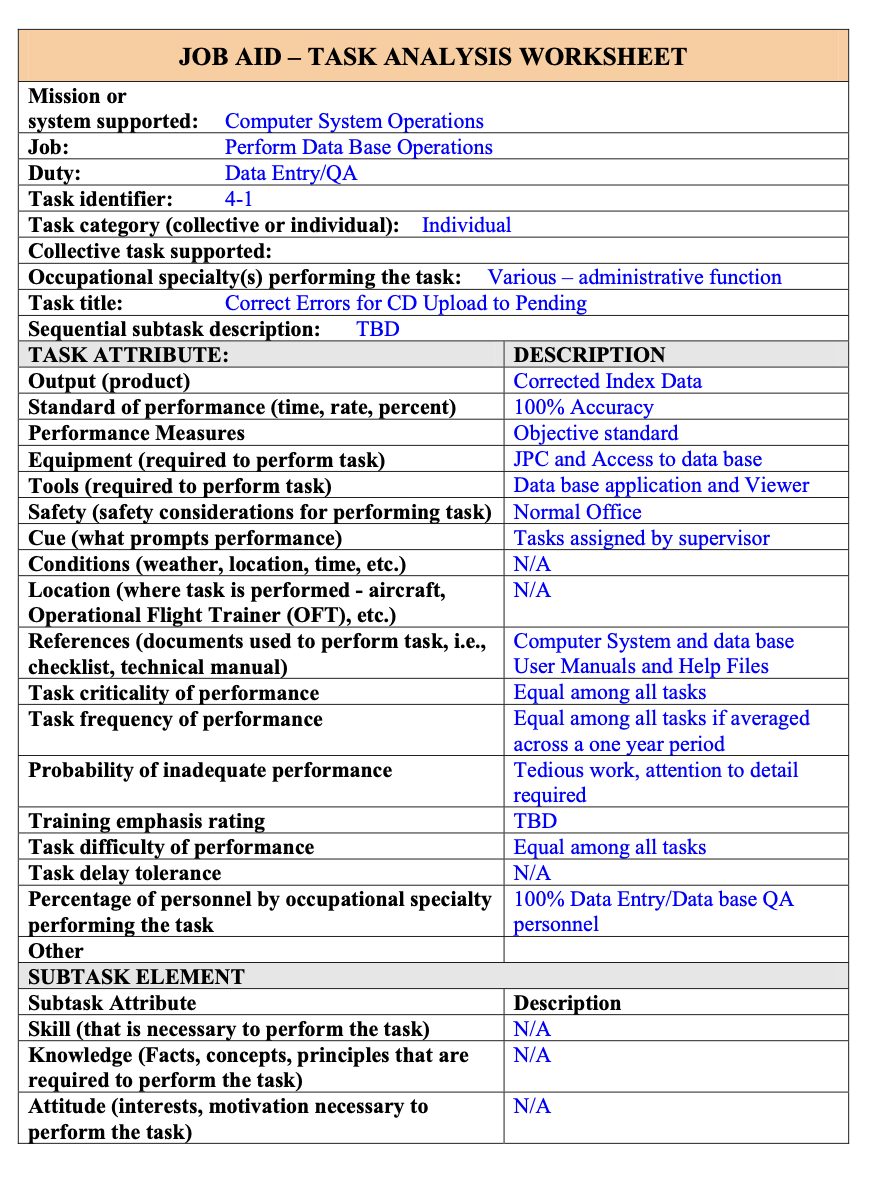

In [28]:
from IPython.display import Image, display

# Assuming Sample_Job_Desc.png is in the /content/ directory
image_path = '/content/Sample_Job_Desc.png'
try:
    display(Image(filename=image_path))
except FileNotFoundError:
    print(f"Error: Image not found at {image_path}")


In [30]:
class Job_Desc(BaseModel):
    """Extract the form number, fiscal start date, fiscal end date, and the plan liabilities beginning of the year and end of the year."""
    Mission: str = Field(description="Mission")
    Job: str = Field(description="Job")
    Duty: str = Field(description="Duty")

result = extract_structured_data("Sample_Job_Desc.pdf", Job_Desc)

print(f'Mission: {result.Mission}')
print(f'Job: {result.Job}')
print(f'Duty: {result.Duty}')



Mission: Computer System Operations
Job: Perform Data Base Operations
Duty: Data Entry/QA
